# Plan de trabajo

Se plantea el siguiente plan de trabajo para modelar el valor total del avaluo de una vivienda a partir de un número definido de características.

- [x] Adicionar información de Puntos de Interes [No se elige porque hay]
- [x] Analizar valores pérdidos
- [x] Aplicar téncicas de imputación
- [x] Evaluar calidad de valores en todas la variables. Por ejemplo, evaluar que tanta variabilidad hay en las variables númericas. Se llega a esto porque hay variables númericas que sólo tienen un valor. Ejemplo 'matricula_garaje_5', 'matricula_inmobiliaria_deposito_3. Hay variables categóricas con problemas en sus valores como lo es **piscina**.
- [x] Evaluar cantidad de valores únicos en la variables categóricas
- [x] Determinar forma de reducir cantidad de valores únicos 
- [x] Elegir variables [Se elimina direccion inmueble porque aumentaría la cantidad de variables de forma exagerada]
- [x] Transformar variables categóricas a variables númericas [Códificación]
- [x] Elegir modelo que sea recomendado en estas condiciones. Light GBM Regressor
- [x] Crear función que permita aplicar la técnica Forward Stepwise
- [x] Crear Learning Curves
- [x] Select Model
- [x] Realizar predicciones
- [x] Recomendaciones
- [x] Despliegue

In [154]:
# Leer datos
import pandas as pd
df = pd.read_excel('entrenamiento_precios_vivienda.xlsx')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12857 entries, 0 to 12856
Columns: 221 entries, fecha_aprobación to id
dtypes: float64(6), int64(17), object(198)
memory usage: 21.7+ MB


# Preprocesamiento
### Adicionar información de Puntos de Interes

No se usa esta información porque hay pocos datos en la columna Longitud de la tabla entrenamiento que se encuentran en la columna Longitud de la tabla puntos de interés. Se recomienda en futuras iteraciones evaluar técnicas que permitan adicionar a los datos de entrenamiento las variables NombrePuntodeInteres y CategoriaPuntodeInteres como por ejemplo aquellas que usen distancias para crear agrupaciones como Kmeans o Agrupación Jerarquica.

In [155]:
# Leer datos
df_pi = pd.read_csv('PuntosInteres.csv', sep=';', encoding_errors='ignore', names=['Longitud', 'Latitud', 'CategoriaPI', 'NombrePI'])

# Longitud común entre tablas
df.Longitud.isin(df_pi.Longitud).sum()

26

### Analizar valores pérdidos

Hay columnas con pocos valores pérdidos. Sólo dos tiene en un porcentaje de valores pérdidos superior al 10% [tipo_subsidio y fecha_aprobación]. Por tanto serán eliminadas del análisis. Por otra parte, el resto de variables con valores pérdidos se les aplicará técnicas de imputación, en el caso de las categóricas se usará el valor más frecuente y las numéricas serán imputadas con el promedio. En futuras iteraciones se recomienda aplicar modelos de machine learning para aplicar la imputación.

In [156]:
num_nan_col = [cd.isnull().sum() / df.shape[0] for cn, cd in df.iteritems()]
name_col = [cn for cn, cd in df.iteritems()]

df_num_nan = pd.DataFrame({'name_col': name_col, 'num_nan':num_nan_col})
df_num_nan[df_num_nan.num_nan > 0].sort_values(by='num_nan', ascending=False).reset_index().drop('index', axis=1)

,name_col,num_nan
0,tipo_subsidio,0.883876
1,fecha_aprobación,0.584351
2,descripcion_uso_inmueble,0.019056
3,descripcion_tipo_inmueble,0.018434
4,descripcion_clase_inmueble,0.018434
5,numero_garaje_1,0.002178
6,observaciones_generales_construccion,0.001556
7,barrio,0.000467
8,numero_garaje_2,0.000311
9,matricula_inmobiliaria_deposito_3,0.000156


In [157]:
# Variables tipo float
columns_num_float = pd.Series([cn if cd.dtype.name == 'float64' else 'None' for cn, cd in df.iteritems()])
columns_num_float = columns_num_float[~columns_num_float.isin(['None'])].tolist()


# Variables tipo integer
columns_num_int = pd.Series([cn if cd.dtype.name == 'int64' else 'None' for cn, cd in df.iteritems()])
columns_num_int = columns_num_int[~columns_num_int.isin(['None'])].tolist()


# Variables tipo categoricas
columns_cat = pd.Series([cn if cd.dtype.name == 'object' else 'None' for cn, cd in df.iteritems()])
columns_cat = columns_cat[~columns_cat.isin(['None'])].tolist()

# Variables numericas
columns_num = columns_num_float + columns_num_int

In [158]:
# Imputación
# Inicializar instancia
from sklearn.impute import SimpleImputer
imp_num_int = SimpleImputer(strategy='median')
imp_cat = SimpleImputer(strategy='most_frequent')

# Aplicar imputación
df_num = pd.DataFrame(imp_num_int.fit_transform(df[columns_num]), columns=imp_num_int.feature_names_in_.tolist())
df_cat = pd.DataFrame(imp_cat.fit_transform(df[columns_cat]), columns=imp_cat.feature_names_in_.tolist())

# DataFrame sin valores pérdidos
df = pd.concat([df_num, df_cat], axis=1)

# Analizar valores de las variables

Se observa que las variables tipo float: 

- 'matricula_garaje_5'
- 'matricula_inmobiliaria_deposito_3' 

no tienen variación, se descartan porque no aportarán a la creación del modelo.

In [159]:
# Númericas float
df[columns_num_float].describe()

,fecha_aprobación,matricula_garaje_5,matricula_inmobiliaria_deposito_3,matricula_inmobiliaria_deposito_4,Longitud,Latitud
count,1.285700e+04,12857.0,12857.0,12857.000000,12857.000000,12857.000000
mean,4.317496e+04,0.0,0.0,0.000078,-50.544378,3.973161
std,1.404887e+04,0.0,0.0,0.008819,35.136926,3.328169
min,4.297933e+04,0.0,0.0,0.000000,-81.729359,-4.219505
25%,4.304671e+04,0.0,0.0,0.000000,-75.562921,0.000000
50%,4.304671e+04,0.0,0.0,0.000000,-74.101304,4.631946
75%,4.304671e+04,0.0,0.0,0.000000,0.000000,6.197968
max,1.636029e+06,0.0,0.0,1.000000,73.640261,13.355871


También se observa no variación en las siguientes variables tipo entero:

- 'matricula_inmobiliaria_deposito_5'
- 'numero_deposito_5'

Por tanto, también se descartarán.

In [160]:
# Númericas int
df[columns_num_int].describe()

,bano_social,bano_servicio,cocina,estudio,balcon,terraza,patio_interior,jardin,zona_de_ropas,zona_verde_privada,local,oficina,bodega,numero_garaje_5,numero_deposito_5,matricula_inmobiliaria_deposito_5,id
count,12857.000000,12857.000000,12857.000000,12857.000000,12857.000000,12857.000000,12857.000000,12857.000000,12857.000000,12857.000000,12857.000000,12857.000000,12857.000000,12857.000000,12857.0,12857.0,12857.000000
mean,1.021778,0.136579,1.065879,0.245469,0.510695,0.211947,0.382204,0.063156,0.965311,0.052501,0.026134,0.010967,0.018745,0.002411,0.0,0.0,9182.685852
std,0.753539,0.377717,0.423449,0.440563,0.663919,0.465473,0.587005,0.252664,0.477767,0.231597,0.208190,0.201784,0.147179,0.273396,0.0,0.0,5290.674433
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,1.000000
25%,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,4621.000000
50%,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,9182.000000
75%,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,13770.000000
max,14.000000,11.000000,13.000000,3.000000,11.000000,9.000000,11.000000,4.000000,13.000000,4.000000,10.000000,9.000000,3.000000,31.000000,0.0,0.0,18331.000000


In [161]:
# Númericas int
# Valores únicos
{cn:cd.unique() for cn, cd in df[columns_num_int].iteritems()}

{'balcon': array([ 0.,  1.,  2.,  3.,  7.,  5.,  4.,  6., 11.]),
 'bano_servicio': array([ 0.,  1.,  2.,  3., 10., 11.]),
 'bano_social': array([ 2.,  0.,  1.,  3.,  4.,  7.,  6.,  5., 11., 14., 12.,  8.]),
 'bodega': array([0., 2., 1., 3.]),
 'cocina': array([ 1.,  2.,  0.,  3.,  8.,  4.,  5., 13.,  7.,  6.]),
 'estudio': array([0., 1., 2., 3.]),
 'id': array([1.0000e+00, 3.0000e+00, 4.0000e+00, ..., 1.8329e+04, 1.8330e+04,
        1.8331e+04]),
 'jardin': array([0., 1., 2., 4., 3.]),
 'local': array([ 0.,  1.,  2.,  4.,  3., 10.]),
 'matricula_inmobiliaria_deposito_5': array([0.]),
 'numero_deposito_5': array([0.]),
 'numero_garaje_5': array([ 0., 31.]),
 'oficina': array([0., 1., 9., 2., 3., 4., 7., 8., 5.]),
 'patio_interior': array([ 0.,  1.,  2., 11.,  3.,  4.,  7.,  5.,  9.]),
 'terraza': array([0., 1., 2., 5., 4., 3., 8., 9.]),
 'zona_de_ropas': array([ 1.,  2.,  0.,  3.,  4., 10.,  5., 13., 11.,  6.]),
 'zona_verde_privada': array([0., 1., 2., 4., 3.])}

Las variables categóricas reflejan el enorme trabajo de preprocesamiento que se debe realizar sobre los datos.

Se hará uso de supuestos para podar muchas variables. Los supuestos estan en función de los tipos de valores únicos que asumen cada una de esas variables. 

Observando los valoes únicos de cada variable categórica hay tres grandes grupos:

1. Números: los valores son representados por números.
2. Categóricas: los valores son representados por palabras, letras y/o números.
3. No Estructurados: son conjuntos de palabras describiendo.

Los supuestos son:

- Toda variable que tenga una descripción donde se valore la vivienda será considerado una variable que pertenece al grupo **No Estructurado**. Como se mencionó previamente se recomienda aplicar sobre estos datos la técnica de analisis de sentimientos y de esa forma aprovechar el gran potencial que tienen ya que proporcionan atributos de calidad a los atributos cuantitativos tradionalmente medidos. Creo que hay oro acá.

- Todas las variables que pertenecen al grupo  **Números** que tienen una cantidad de valores únicos tal que son mostrados en el diccionario de más adelante serán un subgrupo llamado: **Números Inadecuados**. Cuando no se muestran todos los valores únicos hay un indicio de que es una variable con calidad suficiente para ser transformada más adelante como variable númerica, por tanto pertenecerán al subgrupo: **Números Adecuados**. Dentro de ese último subgrupo hay exepciones:
  - bano_privado: el valor que representa una descripción será eliminado.

- Todas las variables que pertenecel al grupo **Categóricas** que contienen como valores únicos palabras y números conformarán el subgrupo **Categóricas Inadecuado** ya que hay ambiguedad para definir el tratamiento adecuado para transformar ciertos números a palabras. Cuando los valores únicos son sólo palabras se estará en presencia del subgrupo **Categóricas Adecuadas**. A este grupo se adicionará una excepción, aquellos variables cuyo valores únicos sean *Si*, *No* y *0* el *0* se transformará por la palabra *No*. Otras exepciones:
  

- Toda variable que pertenezca a algunos de al grupo **No Estructurado** y a los subgrupos **Números Inadecuados** y **Categóricas Inadecuado** serán descartadas.

- Todas las variables del subgrupo **Números Adecuados** serán transformadas a variables númericas.

- Todas aquellas variables que pertenezcan al subgrupo Adecuado pero se deba hacer más de una transformación serán descartadas.

- Todas aquellas variables que pertenecen al subgrupo **Categóricas Adecuadas** pero que algunos valores reflejen una jerarquía pero otras no serán descartadas.

- Se excluye la variable 'barrio'. Se considerá que por cuestiones de tiempo se debe descartar sin emabargo es interesante incluirla en futuras iteraciones.

In [162]:
variables_to_remove = ['id',
                       'tipo_subsidio', 'fecha_aprobacion', # Por Nan
                       'descripcion_clase_inmueble', 'descripcion_general_sector', 'descripcion_tipo_inmueble', 'descripcion_uso_inmueble', # Por Dato No Estructurado
                       'matricula_garaje_5', 'matricula_inmobiliaria_deposito_3', 'matricula_inmobiliaria_deposito_5', 'numero_deposito_5'] # No hay variación

numericas_inadecuadas = ['area_deposito', 'area_libre', 'area_otros', 'indice_construccion', 'indice_ocupacion', 'numero_de_edificios', 'numero_deposito_1', 
                         'numero_deposito_2', 'numero_deposito_3', 'numero_deposito_4', 'numero_garaje_1', 'numero_garaje_2', 'numero_garaje_3', 'numero_garaje_4',
                         'numero_piso', 'numero_total_de_garajes', 'numero_total_depositos', 'pisos_bodega', 'valor_area_deposito', 'valor_area_garaje', 'valor_area_otros',
                         'valor_uvr', 'area_privada', 'valor_area_privada', 'closet', 'comedor', 'barrio', 'valor_avaluo_en_uvr']
numericas_adecuadas = ['area_construccion', 'area_garaje', 'area_terreno', 'area_valorada', 'valor_area_construccion', 'valor_area_libre',
                       'valor_area_terreno', 'valor_total_avaluo']
numericas_adecuadas_exepcion = ['bano_privado']
categoricas_inadecuadas = ['accesorios', 'acueducto_en_el_sector', 'administracion', 'aislamiento_lateral', 'aislamiento_posterior', 'ajustes_sismoresistentes',
                           'alcantarillado_en_el_sector', 'altura_permitida', 'alumbrado', 'antejardin', 'arborizacion', 'area_actividad', 'barrio_legal',
                           'bicicletero', 'calidad_acabados_madera', 'calidad_acabados_muros', 'calidad_acabados_techos',
                           'citofono', 'clase_inmueble', 'condiciones_salubridad', 'contadores_agua', 'contadores_luz', 'cuarto_servicio', 'cubierta',
                           'danos_previos', 'demanda_interes', 'detalle_material', 'direccion_inmueble_informe',
                           'energia_en_el_predio', 'estado_acabados_madera', 'estar_habitacion', 'estado_acabados_techos', 'estrato', 'estructura',
                           'estructura_reforzada', 'fachada', 'garaje_cubierto_1', 'garaje_cubierto_2', 'garaje_doble_1', 'garaje_paralelo_1', 'gas_en_el_predio',
                           'habitaciones', 'iluminacion', 'irregularidad_altura', 'irregularidad_planta', 'material_de_construccion', 'matricula_garaje_1',
                           'matricula_garaje_2', 'matricula_garaje_3', 'matricula_garaje_4', 'matricula_inmobiliaria_deposito_1', 'matricula_inmobiliaria_deposito_2',
                           'motivo', 'observaciones_aislamiento_lateral', 'observaciones_aislamiento_posterior', 'observaciones_altura_permitida', 'observaciones_antejardin',
                           'ocupante', 'paradero', 'piscina', 'porteria', 'predio_subdividido_fisicamente', 'proposito', 'rph', 'sala', 'sector', 'sometido_a_propiedad_horizontal',
                           'tanque_de_agua', 'telefono_en_el_predio', 'tipo_fachada', 'topografia_sector', 'total_cupos_parquedaro', 'transporte', 'unidades', 'uso_actual', 'uso_principal_ph',
                           'ventilacion', 'vetustez', 'tipo_inmueble', 'nivel_equipamiento_comercial']
categoricas_adecuadas = ['alamedas', 'andenes_en_las_vias', 'calidad_acabados_banos', 'calidad_acabados_cocina', 'calidad_acabados_metal', 'ciclo_rutas',
                         'departamento_inmueble', 'energia_en_el_sector', 'estado_acabados_banos', 'estado_acabados_cocina', 'estado_acabados_metal', 'municipio_inmueble',
                         'sardineles_en_las_vias', 'telefono_en_el_sector', 'tipo_avaluo', 'tipo_subsidio', 'vias_pavimentadas']
categoricas_adecuadas_exepcion = ['club_house', 'garaje_cubierto_3', 'garaje_cubierto_4', 'garaje_cubierto_5', 'garaje_doble_2', 'garaje_doble_3', 
                                  'garaje_doble_4', 'garaje_doble_5', 'garaje_paralelo_2', 'garaje_paralelo_3', 'garaje_paralelo_4', 'garaje_paralelo_5',
                                  'garaje_servidumbre_1', 'garaje_servidumbre_2', 'garaje_servidumbre_3', 'garaje_servidumbre_4', 'garaje_servidumbre_5',
                                  'garaje_visitantes', 'gas_en_el_sector', 'objeto', 'sauna', 'teatrino', 'tipo_credito', 'tipo_deposito', 'tipo_garaje', 'tipo_vigilancia',
                                  'vigilancia_privada']
no_estructurado = ['actualidad_edificadora', 'acueducto_en_el_predio', 'alcantarillado_en_el_predio', 'calidad_acabados_pisos', 'comportamiento_oferta_demanda',
                   'concepto_del_metodo_1', 'concepto_del_metodo_2', 'concepto_del_metodo_3', 'concepto_del_metodo_4', 'concepto_del_metodo_5', 'concepto_del_metodo_6',
                   'concepto_del_metodo_7', 'concepto_del_metodo_8', 'concepto_del_metodo_9', 'condicion_ph', 'descripcion_clase_inmueble', 'descripcion_general_sector',
                   'descripcion_tipo_inmueble', 'descripcion_uso_inmueble', 'estado_acabados_muros', 'estado_acabados_pisos', 'metodo_valuacion_1',
                   'metodo_valuacion_2', 'metodo_valuacion_3', 'metodo_valuacion_4', 'metodo_valuacion_5', 'metodo_valuacion_6', 'metodo_valuacion_7',
                   'metodo_valuacion_8', 'metodo_valuacion_9', 'observaciones_dependencias', 'observaciones_estructura', 'observaciones_generales_construccion',
                   'observaciones_generales_inmueble', 'observaciones_indice_construccion', 'observaciones_indice_ocupacion', 'perspectivas_de_valorizacion']

Estuve pensando en modelos :D para hacer esta tarea. Pero me tomaría mucho tiempo, además debo de etiquetar algunas variables. Así que las etiquetaré todas.

In [ ]:
import numpy as np
{cn:np.median([len(e) for e in cd.unique()]) for cn, cd in df[columns_cat].iteritems()}

In [163]:
# Categóricas
{cn:cd.unique() for cn, cd in df[categoricas_adecuadas + categoricas_adecuadas_exepcion].iteritems()}

{'alamedas': array(['Si', 'No'], dtype=object),
 'andenes_en_las_vias': array(['Si', 'No'], dtype=object),
 'calidad_acabados_banos': array(['Normal', 'Sencillo', 'Bueno', 'Lujoso', 'Sin Acabados', 'Regular',
        'Malo'], dtype=object),
 'calidad_acabados_cocina': array(['Integral', 'Sencillo', 'Semi-Integral', 'Bueno', 'Sin Acabados',
        'Lujoso', 'Normal', 'Regular'], dtype=object),
 'calidad_acabados_metal': array(['Normal', 'Sencillo', 'Bueno', 'Sin Acabados', 'Lujoso', 'Regular'],
       dtype=object),
 'ciclo_rutas': array(['Si', 'No'], dtype=object),
 'club_house': array(['No', '0', 'Si'], dtype=object),
 'departamento_inmueble': array(['CUNDINAMARCA', 'SUCRE', 'VALLE DEL CAUCA', 'NARIÑO', 'ANTIOQUIA',
        'CAUCA', 'BOGOTÁ, D. C.', 'TOLIMA', 'HUILA', 'ATLÁNTICO',
        'CÓRDOBA', 'RISARALDA', 'SANTANDER', 'BOLÍVAR', 'CESAR',
        'NORTE DE SANTANDER', 'META', 'MAGDALENA', 'CALDAS', 'BOYACÁ',
        'PUTUMAYO', 'QUINDÍO', 'CASANARE', 'CAQUETÁ',
        'Anatild

In [164]:
# Transformación
df_cat_ade = df[categoricas_adecuadas + categoricas_adecuadas_exepcion]
for cn, cd in df_cat_ade.iteritems():
  
  df_cat_ade[cn] = df_cat_ade[cn].apply(lambda x: x.replace('Sin acabados', 'Sin Acabados'))
  df_cat_ade[cn] = df_cat_ade[cn].apply(lambda x: x.replace('0', 'No'))
  df_cat_ade[cn] = df_cat_ade[cn].apply(lambda x: x.replace('OriginaciÃ³n', 'Originación'))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-doc

Revisando valores únicos dentro de los subgrupos Adecuados:

- En el grupo **Números Adecuados** y **Números Adecuados Excepcion** se observa algunos números que tienen coma como separador decimal. Se cambian por punto. Luego se transforman a formato float. Y el valor no númerico que tiene la variable bano_privado se eliminará.

In [165]:
{cn:cd.unique() for cn, cd in df[numericas_adecuadas + numericas_adecuadas_exepcion].iteritems()}

{'area_construccion': array(['0', '92', '63,6', ..., '77.099999999999994', '66.45', '118.2'],
       dtype=object),
 'area_garaje': array(['0', '13,32', '43,1', ..., '80.45', '26.902999999999999', '22.2'],
       dtype=object),
 'area_terreno': array(['0', '154', '36', ..., '39.369999999999997', '126.75', '128.5'],
       dtype=object),
 'area_valorada': array(['53,33', '92', '49,13', ..., '59.36', '52.73', '108.35'],
       dtype=object),
 'bano_privado': array(['0', '2', '1', '4', '3',
        'el cual transmite todo el piso de la estructura a la placa de cimentación, también tiene un sistema de columnas aporticadas. Placas de entrepiso aligeradas, y cubierta en concreto reforzado."',
        '7', '5', '20', '13', '9', '6', '8', '11', '24', '12'],
       dtype=object),
 'valor_area_construccion': array(['0', '49774000,08', '49290000,0', ..., '103680000', '112590000',
        '27048000'], dtype=object),
 'valor_area_libre': array(['0', '483346350,00', '97650000,0', ..., '152999300', '

In [166]:
# Transformación
df_num_ade = df[numericas_adecuadas]
for cn, cd in df_num_ade.iteritems():
  df_num_ade[cn] = df_num_ade[cn].apply(lambda x: x.replace(',', '.'))
  df_num_ade[cn] = df_num_ade[cn].apply(lambda x: x.replace('No', '0'))
  df_num_ade[cn] = df_num_ade[cn].astype('float')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation:

  - En las variables **Categoricas Adecuadas** y **Categoricas Adecuadas Excepcion** se transformará el valor 'Sin acabados' por 'Sin Acabados' y '0' por 'No' y en el valor '2018-06-19 19:48:27.269-05' de la variable objeto será eliminado.

In [167]:
# Union df_num_ade con df_cat_ade
dfw = pd.concat([df_num_ade, df_cat_ade, df[numericas_adecuadas_exepcion]], axis=1)

# Se eliminan las unicas observaciones de dos variables que un valor sin sentido.
dfw = dfw[~(dfw.bano_privado == 'el cual transmite todo el piso de la estructura a la placa de cimentación, también tiene un sistema de columnas aporticadas. Placas de entrepiso aligeradas, y cubierta en concreto reforzado."')]
dfw = dfw[~(dfw.objeto == '2018-06-19 19:48:27.269-05')]
dfw.shape

(12856, 53)

Se evaluan los valores unicos de las variables asociadas a lugares geográficos

In [168]:
# Evaluando los valores asociados a lugares geográficos
categoricas_geof = ['departamento_inmueble', 'municipio_inmueble']

df_cat_geo = dfw[categoricas_geof]
for cn, cd in df_cat_geo.iteritems():
  
  df_cat_geo[cn] = df_cat_geo[cn].apply(lambda x: x.replace('ARCHIPIÃ‰LAGO DE SAN ANDRÃ‰S, PROVIDENCIA Y', 'SAN ANDRES'))
  df_cat_geo[cn] = df_cat_geo[cn].apply(lambda x: x.replace('ARCHIPIÉLAGO DE SAN ANDRÉS, PROVIDENCIA Y', 'SAN ANDRES'))
  df_cat_geo[cn] = df_cat_geo[cn].apply(lambda x: x.replace('ATLÃNTICO', 'ATLÁNTICO'))
  df_cat_geo[cn] = df_cat_geo[cn].apply(lambda x: x.replace('BOGOTÃ, D. C.', 'BOGOTÁ, D. C.'))
  df_cat_geo[cn] = df_cat_geo[cn].apply(lambda x: x.replace('BOLÃVAR', 'BOLÍVAR'))
  df_cat_geo[cn] = df_cat_geo[cn].apply(lambda x: x.replace('BOYACÃ', 'BOLÍVAR'))
  df_cat_geo[cn] = df_cat_geo[cn].apply(lambda x: x.replace('CAQUETÃ', 'CAQUETÁ'))
  df_cat_geo[cn] = df_cat_geo[cn].apply(lambda x: x.replace('CHOCÃ“', 'CHOCÓ'))
  df_cat_geo[cn] = df_cat_geo[cn].apply(lambda x: x.replace('CÃ“RDOBA', 'CÓRDOBA'))
  df_cat_geo[cn] = df_cat_geo[cn].apply(lambda x: x.replace('GUAINÃA', 'GUAINÍA'))
  df_cat_geo[cn] = df_cat_geo[cn].apply(lambda x: x.replace('NARIÃ‘O', 'NARIÑO'))
  df_cat_geo[cn] = df_cat_geo[cn].apply(lambda x: x.replace('QUINDÃO', 'QUINDÍO'))
  df_cat_geo[cn] = df_cat_geo[cn].apply(lambda x: x.replace('BOGOTÃ\x81, D. C.', 'BOGOTÁ, D. C.'))
  df_cat_geo[cn] = df_cat_geo[cn].apply(lambda x: x.replace('COVEÃ‘AS', 'COVEÑAS'))
  df_cat_geo[cn] = df_cat_geo[cn].apply(lambda x: x.replace('OCAÃ‘A', 'OCAÑA'))
  df_cat_geo[cn] = df_cat_geo[cn].apply(lambda x: x.replace('OCAÃ‘A', 'OCAÑA'))


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pan

In [169]:
# Adicionando transformaciones
dfw = pd.concat([dfw.drop(categoricas_geof, axis=1), df_cat_geo], axis=1)

# Valores a eliminar
dep_eli_val = ['Alicia Maria Velez Restrepo', 'Anatilde Toro Echavarria', 'Andres Felipe Orozco Vasquez', 'Claudia cecilia Restrepo Alzate',
               'Franco Emilio Ayala', 'Lara Gomez Miguel Eduardo', 'Ochoa Vahos Alba del Carmen', 'Oscar Romel Castellanos Virguez y Otro',
               'Rios Duque Sandra Rafaela', 'Velasquez Chica Enit Juliet']

mun_eli_val = ['Clara Ines Restrepo Alzate', 'Ochoa Vahos Alejandra', 'Ochoa Vahos Alejandra']

# Eliminando los valores inadecuados de la variable departamento_inmueble
for col in categoricas_geof:
  print(col)
  if col == 'departamento_inmueble':
    for dvi in dep_eli_val:
      print(dvi)
      print(dfw.shape)
      dfw = dfw[~(dfw[col] == dvi)]
      print(dfw.shape)
  else:
    for mvi in mun_eli_val:
      print(mvi)
      print(dfw.shape)
      dfw = dfw[~(dfw[col] == mvi)]
      print(dfw.shape)

departamento_inmueble
Alicia Maria Velez Restrepo
(12856, 53)
(12855, 53)
Anatilde Toro Echavarria
(12855, 53)
(12854, 53)
Andres Felipe Orozco Vasquez
(12854, 53)
(12853, 53)
Claudia cecilia Restrepo Alzate
(12853, 53)
(12852, 53)
Franco Emilio Ayala
(12852, 53)
(12851, 53)
Lara Gomez Miguel Eduardo
(12851, 53)
(12850, 53)
Ochoa Vahos Alba del Carmen
(12850, 53)
(12849, 53)
Oscar Romel Castellanos Virguez y Otro
(12849, 53)
(12848, 53)
Rios Duque Sandra Rafaela
(12848, 53)
(12847, 53)
Velasquez Chica Enit Juliet
(12847, 53)
(12846, 53)
municipio_inmueble
Clara Ines Restrepo Alzate
(12846, 53)
(12846, 53)
Ochoa Vahos Alejandra
(12846, 53)
(12846, 53)
Ochoa Vahos Alejandra
(12846, 53)
(12846, 53)


# Crear Modelo

- Se corren modelos con una sola variable. Luego se corren modelos de dos variables y así sucesivamente hata estimar el modelo con todas las variables. Finalmente se elige el modelo ganador.
  - Se estandarizarán las variables númericas
  - Se codificarán las variables categoricas

In [171]:
# Borrar espacios en los valores de departamento y municipios
dfw['departamento_inmueble'] = dfw.departamento_inmueble.apply(lambda x: x.replace(' ', ''))
dfw['municipio_inmueble'] = dfw.municipio_inmueble.apply(lambda x: x.replace(' ', ''))

# Crear Variable dep_mun_inmueble
dfw['dep_mun_inmueble'] = dfw.departamento_inmueble + ' ' + dfw.municipio_inmueble

# Eliminar variables Departamento y municipio
dfw = dfw.drop(['departamento_inmueble', 'municipio_inmueble'], axis=1)

In [172]:
# Dividir Datos
from sklearn.model_selection import train_test_split
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_absolute_percentage_error as mape
from sklearn.preprocessing import StandardScaler, PolynomialFeatures, OneHotEncoder
from sklearn.feature_extraction.text import CountVectorizer

# Seleccionar variables
dfw_X = dfw.drop('valor_total_avaluo', axis=1)
dfw_y = dfw.valor_total_avaluo
X_train, X_test, y_train, y_test = train_test_split(dfw_X, dfw_y, test_size=0.2, random_state=220530)
y_train.shape

(10276,)

In [174]:
# Standarizar la variable dependiente
import numpy as np
scaler_y = StandardScaler()
# scaler_y.fit_transform(y_train.values.reshape(-1,1))
# scaler_y.inverse_transform(np.array([-0.02580413]).reshape(-1,1))

In [73]:
y_train_st = scaler_y.fit_transform(y_train.values.reshape(-1,1))
y_train_st = [e[0] for e in y_train_st]

y_test_st = scaler_y.fit_transform(y_test.values.reshape(-1,1))
y_test_st = [e[0] for e in y_test_st] 

In [176]:
import seaborn as sns
df_borrar = pd.DataFrame({'y_st':y_train_st})
# sns.histplot(x='y_st', data=df_borrar)
df_borrar.y_st.describe()

count    1.027600e+04
mean     1.437477e-17
std      1.000049e+00
min     -2.717040e-02
25%     -2.581495e-02
50%     -2.506675e-02
75%     -2.366275e-02
max      6.757233e+01
Name: y_st, dtype: float64

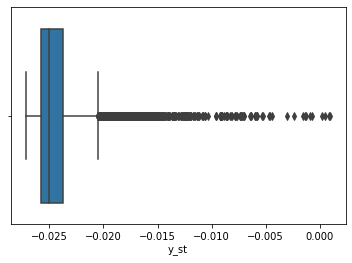

In [177]:
sns.boxplot(x=df_borrar[df_borrar < 0.001].y_st)

In [178]:
# num_var = dfw.shape[1]

# iters_num_var = [i + 1 for i in range(num_var)]

# nombre_columnas = X_train.columns.tolist()

# Obtener todos los posibles modelos
df_all_names = pd.DataFrame({'all_names': [' '.join(X_train.columns.tolist())]})
vectorizer = CountVectorizer(analyzer='word', ngram_range=(1,53))
all_combs = pd.DataFrame(vectorizer.fit_transform(df_all_names.all_names).toarray(), columns=list(vectorizer.get_feature_names_out())).columns.tolist()
all_combs = [e.split(' ') for e in all_combs]

# Data frame para almacenar información importante
df_summary = pd.DataFrame()

# Run all models and save main info
for i, comb in enumerate(all_combs):
  print('Modelo número: ', i + 1)

  # Select variables
  X_iter = dfw_X[comb]
  X_iter_train = X_train[comb]
  X_iter_test = X_test[comb]

  # # remove list with columns of interest
  # del col_cat, col_num, df_model

  # Variables tipo categoricas
  col_cat_train = pd.Series([cn if cd.dtype.name == 'object' else 'None' for cn, cd in X_iter_train.iteritems()])
  col_cat_train = col_cat_train[~col_cat_train.isin(['None'])].tolist()

  # Variables tipo numericas
  col_num_train = pd.Series([cn if cd.dtype.name != 'object' else 'None' for cn, cd in X_iter_train.iteritems()])
  col_num_train = col_num_train[~col_num_train.isin(['None'])].tolist()
  print(comb)
  # print(col_num)
  # print(X_train[col_num])
  # print(col_cat_train)
  # print(len(col_cat_train))
  # print(X_train[col_cat])

  # Codificar
  if len(col_cat_train) > 0:
    encoder_iter = OneHotEncoder()
    encoder_iter.fit(X_iter[col_cat_train])
    df_col_cat_train = pd.DataFrame(encoder_iter.transform(X_train[col_cat_train]).toarray(), columns=encoder_iter.get_feature_names_out())
    df_col_cat_test = pd.DataFrame(encoder_iter.transform(X_test[col_cat_train]).toarray(), columns=encoder_iter.get_feature_names_out())

  # Standarizar
  # print(col_num_train)
  # print(len(col_num_train))
  # Estandarizar las variables númericas
  if len(col_num_train) > 0:
    scaler_train = StandardScaler()
    scaler_test = StandardScaler()
    df_col_num_train = pd.DataFrame(scaler_train.fit_transform(X_train[col_num_train]), columns=scaler_train.get_feature_names_out())
    df_col_num_test = pd.DataFrame(scaler_test.fit_transform(X_test[col_num_train]), columns=scaler_test.get_feature_names_out())

  # Unir dataframes
  if ((len(col_cat_train) > 0) & (len(col_num_train) == 0)):
    df_model_train = df_col_cat_train
    df_model_test = df_col_cat_test
  elif ((len(col_num_train) > 0) & (len(col_cat_train) == 0)):
    df_model_train = df_col_num_train
    df_model_test = df_col_num_test
  else:
    df_model_train = pd.concat([df_col_cat_train, df_col_num_train], axis=1)
    df_model_test = pd.concat([df_col_cat_test, df_col_num_test], axis=1)

  # print(df_model_train.info())
  # print(df_model_test.info())

  # Ajustar modelos
  lgbm_train = LGBMRegressor(random_state=220530)
  lgbm_train.fit(df_model_train, y_train_st)

  # Predicciones
  pred_train = lgbm_train.predict(df_model_train)
  pred_test = lgbm_train.predict(df_model_test)

  # Evaluar modelo
  mape_train = mape(y_train_st, list(pred_train))
  mape_test = mape(y_test_st, list(pred_test))

  # Guardar información importante
  df_summary = pd.concat([df_summary,
                          pd.DataFrame(
                              {'comb':" ".join(comb),
                               'cant_vbles':len(df_model_train.columns.tolist()),
                               'Train_MAPE': mape_train,
                               'Test_MAPE': mape_test  
                              }, index=[0])])




Modelo número:  1
['alamedas']
Modelo número:  2
['alamedas', 'andenes_en_las_vias']
Modelo número:  3
['alamedas', 'andenes_en_las_vias', 'calidad_acabados_banos']
Modelo número:  4
['alamedas', 'andenes_en_las_vias', 'calidad_acabados_banos', 'calidad_acabados_cocina']
Modelo número:  5
['alamedas', 'andenes_en_las_vias', 'calidad_acabados_banos', 'calidad_acabados_cocina', 'calidad_acabados_metal']
Modelo número:  6
['alamedas', 'andenes_en_las_vias', 'calidad_acabados_banos', 'calidad_acabados_cocina', 'calidad_acabados_metal', 'ciclo_rutas']
Modelo número:  7
['alamedas', 'andenes_en_las_vias', 'calidad_acabados_banos', 'calidad_acabados_cocina', 'calidad_acabados_metal', 'ciclo_rutas', 'energia_en_el_sector']
Modelo número:  8
['alamedas', 'andenes_en_las_vias', 'calidad_acabados_banos', 'calidad_acabados_cocina', 'calidad_acabados_metal', 'ciclo_rutas', 'energia_en_el_sector', 'estado_acabados_banos']
Modelo número:  9
['alamedas', 'andenes_en_las_vias', 'calidad_acabados_banos'

In [179]:
# df_summary['cant_vbles_real'] = [len(e.split(' ')) for e in df_summary.comb]
df_summary.sort_values('Test_MAPE').iloc[:10,:]

,comb,cant_vbles,Train_MAPE,Test_MAPE
0,valor_area_libre,1,1.012337,0.502042
0,area_construccion area_garaje,2,1.728859,0.541326
0,area_construccion area_garaje area_terreno,3,1.445899,0.688408
0,area_garaje area_terreno area_valorada,3,1.647229,0.738855
0,area_garaje,1,1.270311,0.760354
0,area_construccion area_garaje area_terreno are...,4,1.684768,0.770894
0,area_garaje area_terreno,2,1.413495,0.784241
0,area_valorada,1,1.197810,0.907998
0,area_valorada valor_area_construccion valor_ar...,3,1.452955,0.911699
0,valor_area_construccion,1,1.547630,0.927275


# Modelo Ganador

El modelo ganador es un modelo con una sola variable explicadora: *valor_area_libre*.

En términos de desempeño del modelo se observó:

- Train_MAPE = 1.012337
- Test_MAPE = 0.502042

Se evidencia problemas de **Underfitting** ya que la métrica de evaluación en datos de prueba es mejor que en datos de entrenamiento.

Para solucionar este problema se recomienda adicionar nuevas variables, como por ejemplo las que tiene la tabla que fueron descartadas por motivos de presentar ambiguedad. Realizar un trabajo de preprocesamiento más profundo sobre estas variables son el camino más factible y veloz para intentar mejorar el desempeño del modelo. Ver en recomendación como aplicar este preprocesamiento.

Otra forma es aplicar técnicas de ajustes de hiperparametros con el proposito de hacer más complejo el modelo. Finalmente, también sería una estrategia adecuada, ajustar modelos más complejos.

# Recomendaciones

Antes de buscar otras variables se debería evaluar las variables descartadas:

- Se recomienda en futuras iteraciones evaluar técnicas que permitan adicionar a los datos de entrenamiento las variables NombrePuntodeInteres y CategoriaPuntodeInteres como por ejemplo aquellas que usen distancias para crear agrupaciones como Kmeans o Agrupación Jerarquica.

- Aplicar analisis de sentimiento en las variables relacionadas a descripciones.

- Variables están en el grupo **Numericas Adecuadas** pero que poseen valores diferentes a números aplicar analisis para evaluar la cantidad real de valores númericos que se poseen y determinar si es buen camino eliminar esos datos problematicos.


Usar de otra forma variables utilizadas:

- Aplicar CountVectorizer a variables geográficas y variables que miden calidad o estado del bien inmueble.

Usar outlier de la variable dependiente para identificar patrones y otras variables.


In [191]:
# Uso de CountVectorizer
from sklearn.feature_extraction.text import CountVectorizer
df_test = pd.DataFrame({'depmun': ['antioquia medellin', 'cundinamarca bogota']})
vectorizer = CountVectorizer(analyzer='word', ngram_range=(1,2))
pd.DataFrame(vectorizer.fit_transform(df_test.depmun).toarray(), columns=list(vectorizer.get_feature_names_out()))

,antioquia,antioquia medellin,bogota,cundinamarca,cundinamarca bogota,medellin
0,1,1,0,0,0,1
1,0,0,1,1,1,0


# Implementación

Se proponen los siguientes pasos para disponibilizar el modelo:

1. Guardar Modelo
2. Crear aplicativo web [FLASK] que cargue modelo paso 1 y que sea un aplicativo tipo **POST**. Su input sería un archivo .json con las variables del modelo ganador

```
{
  'valor_area_libre': 5678900
}
```

y su output sería un archivo .json con sólo un valor:

```
{
  'prediction_modelo': 23500000
}
```
3. Dockerizar
4. Implementar en App Service de alguna nube

# Prediccion sobre archivo testeo_precios_vivienda.xlsx

Los datos testeo no posee la variable del modelo ganador. Por tanto se procede a hacer predicciones con las variables del segundo mejor modelo cuyas variables son: *area_construccion* y *area_garaje*

In [241]:
# Ajustar Modelo Ganador sobre todos los datos
scaler_y_win = StandardScaler()
y_win_st = scaler_y_win.fit_transform(dfw_y.values.reshape(-1,1))
y_win_st = [e[0] for e in y_win_st]

# Estandarizar
scaler_X_win = StandardScaler()
scaler_X_win.fit(dfw_X[['area_construccion', 'area_garaje']])
X_win_st = scaler_X_win.transform(dfw_X[['area_construccion', 'area_garaje']])
X_win_st = pd.DataFrame(X_win_st, columns=scaler_X_win.get_feature_names_out())

lgbm_win = LGBMRegressor(random_state=220530)
# lgbm_win.fit(dfw_X[['valor_area_libre']], y_win_st)
lgbm_win.fit(X_win_st[['area_construccion', 'area_garaje']], y_win_st)

# Evaluar Modelo
pred_win = lgbm_win.predict(X_win_st[['area_construccion', 'area_garaje']])
mape(y_win_st, list(pred_win))

1.4662071200324855

In [242]:
# Leer datos testeo
df_testeo = pd.read_excel('testeo_precios_vivienda.xlsx')
df_testeo.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5385 entries, 0 to 5384
Columns: 211 entries, fecha_aprobación to id
dtypes: datetime64[ns](1), float64(2), int64(44), object(164)
memory usage: 8.7+ MB


In [243]:
pd.Series(df_testeo.columns.tolist()).sort_values().tolist()

['Latitud',
 'Longitud',
 'accesorios',
 'actualidad_edificadora',
 'acueducto_en_el_predio',
 'acueducto_en_el_sector',
 'administracion',
 'aislamiento_lateral',
 'aislamiento_posterior',
 'ajustes_sismoresistentes',
 'alamedas',
 'alcantarillado_en_el_predio',
 'alcantarillado_en_el_sector',
 'altura_permitida',
 'alumbrado',
 'andenes_en_las_vias',
 'antejardin',
 'arborizacion',
 'area_actividad',
 'area_construccion',
 'area_deposito',
 'area_garaje',
 'area_libre',
 'area_otros',
 'area_privada',
 'area_terreno',
 'area_valorada',
 'balcon',
 'bano_privado',
 'bano_servicio',
 'bano_social',
 'barrio',
 'barrio_legal',
 'bicicletero',
 'bodega',
 'calidad_acabados_banos',
 'calidad_acabados_cocina',
 'calidad_acabados_madera',
 'calidad_acabados_metal',
 'calidad_acabados_muros',
 'calidad_acabados_pisos',
 'calidad_acabados_techos',
 'ciclo_rutas',
 'citofono',
 'clase_inmueble',
 'closet',
 'club_house',
 'cocina',
 'comedor',
 'comportamiento_oferta_demanda',
 'concepto_del_m

In [244]:
# Transformación
df_t = df_testeo[['area_construccion', 'area_garaje']]
for cn, cd in df_t.iteritems():
  df_t[cn] = df_t[cn].apply(lambda x: x.replace(',', '.'))
  df_t[cn] = df_t[cn].apply(lambda x: x.replace('No', '0'))
  df_t[cn] = df_t[cn].astype('float')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation:

In [247]:
# Estandarizacion
df_t_st = pd.DataFrame(scaler_X_win.transform(df_t),columns=scaler_X_win.get_feature_names_out())

In [248]:
# Predicción
pred_win_st = lgbm_win.predict(df_t_st[['area_construccion', 'area_garaje']])

In [254]:
# Predicción en las unidades originales
pred_win = scaler_y_win.inverse_transform(pred_win_st.reshape(-1,1))
pred_win = [e[0] for e in pred_win]
pred_win = [v if v > 0 else 0 for v in pred_win]

In [255]:
# Generación archivo 
df_base_evaluada = pd.DataFrame({'id': df_testeo.id.tolist(),
                                 'valor_total_avaluo': pred_win})
df_base_evaluada.to_csv('base_evaluada.csv', index=False)